## **Interpretable analysis of CTCNet learning**

In [1]:
import pickle
from pprint import pprint
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from thalamocortex.utils import create_data_loaders
from thalamocortex.models import CTCNet
from sklearn.decomposition import PCA
from scipy.special import softmax

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load trained model

In [2]:
model_path = Path("/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/0_CTCNet_TC_multi_pre_activation_reciprocal/model.pth")

In [3]:
model = torch.load(model_path)

In [4]:
model.keys()

odict_keys(['thal.0.weight', 'thal.0.bias', 'thal_to_ctx1_projections.weight', 'thal_to_ctx1_projections.bias', 'thal_to_ctx2_projections.weight', 'thal_to_ctx2_projections.bias', 'ctx1.linear.weight', 'ctx1.linear.bias', 'ctx2.linear.weight', 'ctx2.linear.bias', 'readout.0.weight', 'readout.0.bias'])

Plot weights for input layer neurons according to topographic connectivity to input 

In [5]:
input_layer_weights = model["ctx1.linear.weight"]

In [6]:
input_layer_weights.shape

torch.Size([64, 1568])

In [7]:
neuron_id = 1
weights_neuron = input_layer_weights[neuron_id, :].detach().numpy()
weights_neuron_reshaped = np.reshape(weights_neuron, newshape=[28, 56], order="C")

In [8]:
# get min and max vals to plot colourmap
print(f"Min val: {np.min(weights_neuron_reshaped):.3f}, Max val: {np.max(weights_neuron_reshaped):.3f}")

Min val: -0.185, Max val: 0.162


In [9]:
clims = [-0.2, 0.2]

Text(0.5, 1.0, 'input RF')

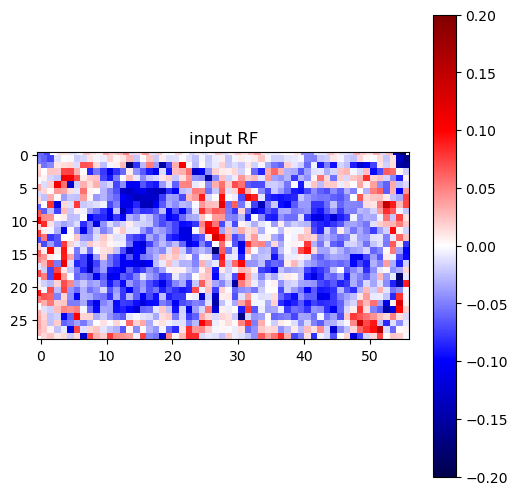

In [10]:
cmap = cm.get_cmap("seismic")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(weights_neuron_reshaped, cmap=cmap)
psm = ax.pcolormesh(weights_neuron_reshaped, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
fig.colorbar(psm, ax=ax)
ax.set_title("input RF")

In [11]:
def get_neuron_weights(weights, neuron_id):
    weights_neuron = weights[neuron_id, :].detach().numpy()
    weights_neuron_reshaped = np.reshape(weights_neuron, newshape=[28, 56], order="C")
    return weights_neuron_reshaped

In [12]:
def plot_receptive_field(weights, ax, cmap, clims, title=None):
    ax.imshow(weights, cmap=cmap)
    ax.set_title(title)
    ax.set_xticks([], [])
    ax.set_yticks([], [])

Text(0.5, 0.98, 'input layer receptive fields')

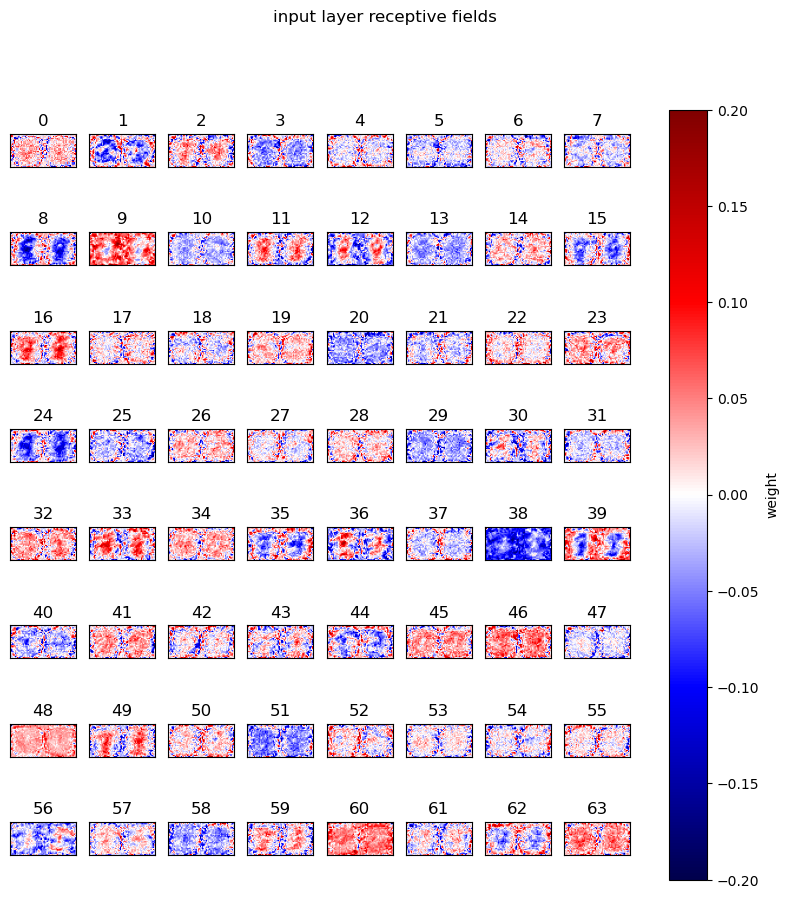

In [13]:
cmap = cm.get_cmap("seismic")
clims = [-0.2, 0.2]

fig, ax = plt.subplots(8, 8, figsize=(10, 10))

for neuron_id in range(64):

    row_idx = neuron_id // 8
    col_idx = neuron_id % 8

    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id)
    plot_receptive_field(weights=weights_this_neuron,
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax)
cbar.set_label("weight")
fig.suptitle("input layer receptive fields")
# fig.set_tight_layout(True)

Text(0.5, 0.98, 'input layer receptive fields')

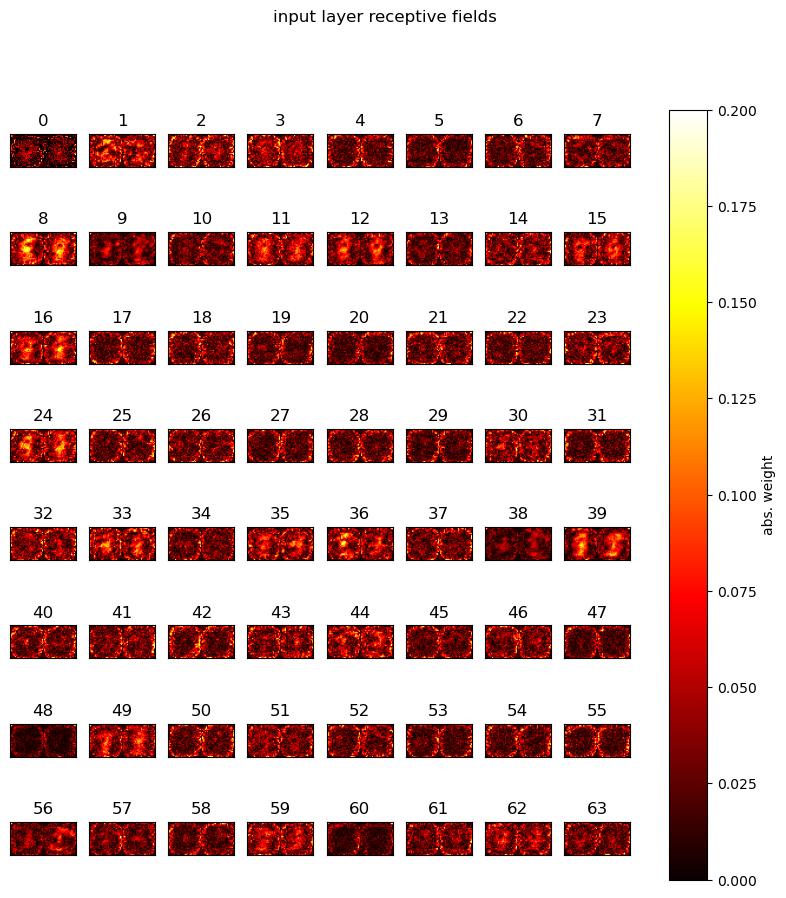

In [14]:
cmap = cm.get_cmap("hot")
clims = [0, 0.2]

fig, ax = plt.subplots(8, 8, figsize=(10, 10))

for neuron_id in range(64):

    row_idx = neuron_id // 8
    col_idx = neuron_id % 8

    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id)
    plot_receptive_field(weights=np.abs(weights_this_neuron),
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax)
cbar.set_label("abs. weight")
fig.suptitle("input layer receptive fields")
# fig.set_tight_layout(True)

Decompose training set and plot principal components

In [15]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset="LeftRightMNIST", norm="normalise", batch_size=32, save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")

In [16]:
# load full training set
X_all = []
y_all = []
for X, y in iter(trainset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])

In [17]:
X.shape

(32, 28, 56)

In [18]:
X_all_arr = np.array(X_all)
y_all_arr = np.array(y_all)
X_all_reshaped = np.reshape(X_all_arr, newshape=(X_all_arr.shape[0] * X_all_arr.shape[1], X_all_arr.shape[2], X_all_arr.shape[3]))
y_all_reshaped = np.reshape(y_all_arr, newshape=(y_all_arr.shape[0] * y_all_arr.shape[1]))
X_all_flat = np.reshape(X_all_reshaped, newshape=(X_all_reshaped.shape[0], X_all_reshaped.shape[1] * X_all_reshaped.shape[2]))

In [19]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(X_all_flat)

PCA(n_components=10)

Text(0, 0.5, 'explained variance')

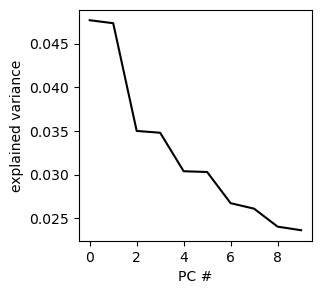

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(pca.explained_variance_ratio_, c="k")
ax.set_xlabel("PC #")
ax.set_ylabel("explained variance")

In [21]:
X_components_reshaped = np.reshape(pca.components_, newshape=(pca.components_.shape[0], 28, 56))

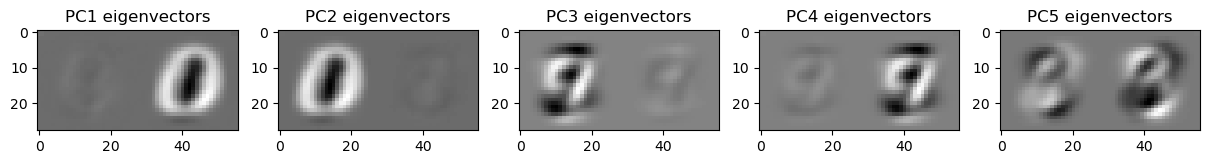

In [22]:
n_plot = 5
fig, ax = plt.subplots(1, n_plot, figsize=(3 * n_plot, 3))
for comp_idx in range(n_plot):
    cmap = cm.get_cmap("grey")
    ax[comp_idx].imshow(X_components_reshaped[comp_idx, :, :], cmap=cmap)
    ax[comp_idx].set_title(f"PC{comp_idx+1} eigenvectors")

# TODO: plot eigenvectors in same style as plots above

Plot variance of training set

In [23]:
X_var = np.var(X_all_reshaped, axis=0)

Text(0.5, 1.0, 'training set variance')

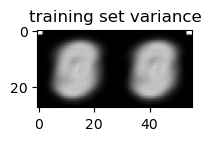

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(X_var, cmap="grey")
ax.set_title("training set variance")

In [25]:
model["thal.0.weight"].shape

torch.Size([16, 128])

Plot weight distributions

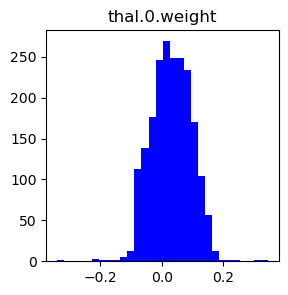

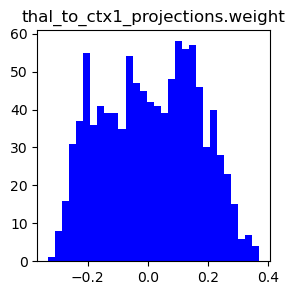

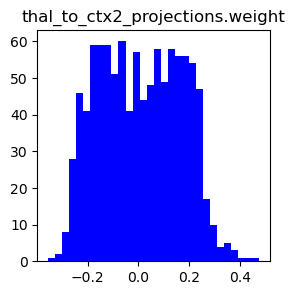

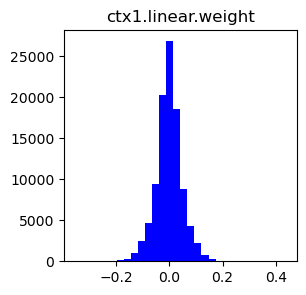

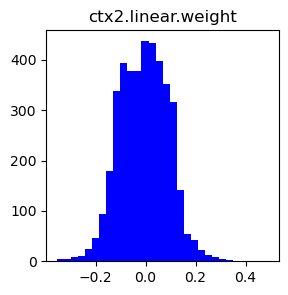

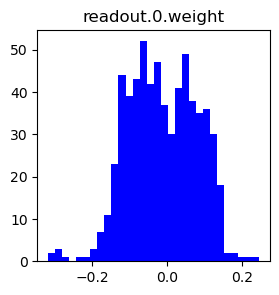

In [26]:
for param_set_name, params in model.items():
    if "weight" in param_set_name:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        params_flat = params.flatten()
        ax.hist(params_flat, bins=30, facecolor="b")
        ax.set_title(f"{param_set_name}")

load model and training report

In [27]:
# training progress and hyperparameter paths
learning_path = Path("/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/0_CTCNet_TC_multi_pre_activation_reciprocal/learning.pkl")
params_path = Path("/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/0_CTCNet_TC_multi_pre_activation_reciprocal/hyperparams.pkl")

In [28]:
# load training progress
with open(learning_path, "rb") as handle:
    learning = pickle.load(handle)
    print(f"{learning.keys()=}")
results = {"val_losses": learning["val_losses"],
                        "train_losses": learning["train_losses"],
                        "train_time": learning["train_time"],
                        "state_dicts": learning["state_dicts"]}

learning.keys()=dict_keys(['train_losses', 'val_losses', 'final_val_losses', 'state_dicts', 'train_time'])


In [29]:
# load hyperparams
with open(params_path, "rb") as handle:
    hp = pickle.load(handle)

In [30]:
hp

{'norm': 'normalise',
 'dataset': 'LeftRightMNIST',
 'save_path': '/Users/patmccarthy/Documents/thalamocortex/data',
 'batch_size': 32,
 'input_size': 1568,
 'output_size': 10,
 'ctx_layer_size': 64,
 'thal_layer_size': 16,
 'thalamocortical_type': 'multi_pre_activation',
 'thal_reciprocal': True,
 'thal_to_readout': False,
 'thal_per_layer': False,
 'lr': 5e-06,
 'loss': CrossEntropyLoss(),
 'epochs': 800,
 'ohe_targets': True,
 'track_loss_step': 50}

In [31]:
# instantiate model
model = CTCNet(input_size=hp["input_size"],
                output_size=hp["output_size"],
                ctx_layer_size=hp["ctx_layer_size"],
                thal_layer_size=hp["thal_layer_size"],
                thalamocortical_type=hp["thalamocortical_type"],
                thal_reciprocal=hp["thal_reciprocal"],
                thal_to_readout=hp["thal_to_readout"], 
                thal_per_layer=hp["thal_per_layer"])

In [32]:
# get model trained to specified epoch
epoch = 200
weights = results["state_dicts"][0]

In [33]:
weights

OrderedDict([('thal.0.weight',
              tensor([[-0.0165, -0.0100,  0.0353,  ...,  0.0268,  0.0541, -0.0005],
                      [ 0.0515, -0.0023,  0.0343,  ..., -0.0538,  0.0523,  0.0534],
                      [ 0.0336,  0.0677,  0.0768,  ...,  0.0459, -0.0273, -0.0043],
                      ...,
                      [-0.0495,  0.0871, -0.0480,  ...,  0.0597,  0.0214,  0.0852],
                      [ 0.0778,  0.0143,  0.1628,  ...,  0.0449, -0.0094,  0.0383],
                      [-0.0070,  0.0341,  0.0703,  ...,  0.0381, -0.0492, -0.0921]])),
             ('thal.0.bias',
              tensor([ 0.0593,  0.0063, -0.0402,  0.0679,  0.2337, -0.0203,  0.1267,  0.0372,
                      -0.0227, -0.0600,  0.0614,  0.0982,  0.0622, -0.0260,  0.1111,  0.0560])),
             ('thal_to_ctx1_projections.weight',
              tensor([[-0.2014, -0.2006, -0.2079,  ...,  0.0336, -0.1844,  0.1968],
                      [ 0.1322, -0.2155,  0.0631,  ..., -0.2208,  0.1441,  0.0158]

In [34]:
# set model weights
model.load_state_dict(weights)

<All keys matched successfully>

load training set

In [35]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset="LeftRightMNIST", norm="normalise", batch_size=32, save_path="/Users/patmccarthy/Documents/ThalamoCortex/data")

In [36]:
# load full training set
X_all = []
y_all = []
for X, y in iter(testset_loader):
    # X_all.append(X.detach().numpy()[:, 0, :, :])
    # y_all.append(y.detach().numpy()[:])
    X_all.append(X[:, :, :])
    y_all.append(y[:])

In [37]:
X_all_arr = np.array(X_all)
y_all_arr = np.array(y_all)
X_all_reshaped = np.reshape(X_all_arr, newshape=(X_all_arr.shape[0] * X_all_arr.shape[1], X_all_arr.shape[2], X_all_arr.shape[3]))
y_all_reshaped = np.reshape(y_all_arr, newshape=(y_all_arr.shape[0] * y_all_arr.shape[1]))

inference

In [38]:
# inference (on full dataset)
y_est_logits = model(torch.Tensor(X_all_reshaped))
y_est_prob = softmax(y_est_logits.detach().numpy())
y_est = np.argmax(y_est_prob, axis=1)

plot examples

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_9859/1481963633.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


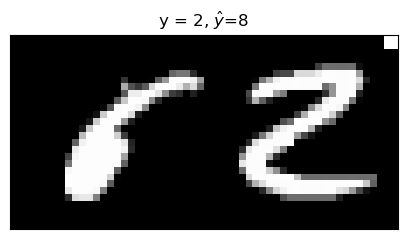

In [39]:
# choose and plot example data point
img_idx = 95
X_i  = X_all_reshaped[img_idx, :, :]
y_i = y_all_reshaped[img_idx]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(X_i, cmap="gray")
ax.set_title(f"y = {y_i:.0f}, $\hat{{y}}$={y_est[img_idx]}")
ax.set_xticks([])
ax.set_yticks([])
fig.show()

In [40]:
y_est_prob.shape

(6976, 10)

In [41]:
y_all_reshaped.shape

(6976,)

In [42]:
y_gt_prob = np.zeros([y_all_reshaped.shape[0], 10])
for samp_idx in range(y_all_reshaped.shape[0]):
    y_gt_prob[samp_idx, y_all_reshaped.astype(int)[samp_idx]] = 1

In [43]:
y_gt_prob.shape

(6976, 10)

compute performance metrics

In [53]:
# CCE
loss = torch.nn.CrossEntropyLoss()
cce = loss(torch.Tensor(y_est_logits), torch.Tensor(y_gt_prob))

In [46]:
# top1
def top1_error(output, target):
    """
    Computes the Top-1 error given model output and target labels.
    
    Args:
        output (torch.Tensor): Model predictions (logits), shape (batch_size, num_classes).
        target (torch.Tensor): Ground truth labels, shape (batch_size,).
    
    Returns:
        float: Top-1 error (misclassification rate).
    """
    with torch.no_grad():
        pred = np.argmax(output, axis=1)  # Get index of max logit
        correct = np.equal(pred, target.astype(int)).sum()
        total = target.shape[0]  # Total samples
        top1_acc = correct / total  # Compute accuracy
        top1_err = 1 - top1_acc  # Compute error
    return top1_err


In [47]:
err = top1_error(y_est_prob, y_all_reshaped)

In [48]:
print(f"top-1 accuracy: {100 - err * 100:.2f}%")

top-1 accuracy: 72.38%


compute and plot gradients

In [ ]:
# get gradients
cce.backward()
grads = {}
for name, param in model.named_parameters():
    grads[name] = param.grad

In [67]:
thal1_proj_grads = grads["thal_to_ctx1_projections.weight"].detach().numpy().T

Text(0.5, 1.0, 'thal2ctx1 weights')

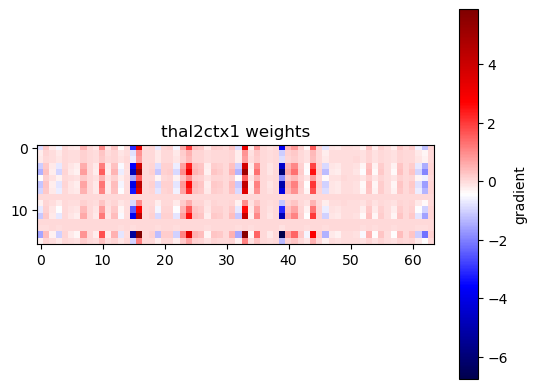

In [79]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(thal1_proj_grads, cmap="seismic")
cbar = plt.colorbar(im)
cbar.set_label("gradient")
ax.set_title("thal2ctx1 weights")

choose example, perform inference, and record activations

In [ ]:
#

In [84]:
# Dictionary to store activations
activations = {}
# Hook function to store activations
def hook_fn(module, input, output):
    """
    module: module name
    input: layer input
    output: layer output
    """
    activations[module] = output

In [ ]:
# Register hooks for specific layers
hook_handles = []
for name, layer in model.named_modules():
    handle = layer.register_forward_hook(hook_fn)
    hook_handles.append(handle)

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_9859/3618707616.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


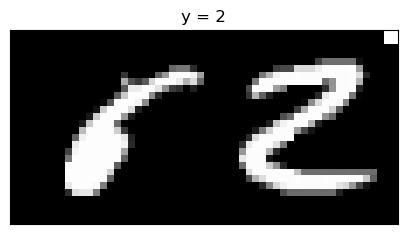

In [86]:
# choose and plot example data point
img_idx = 95
X_i  = X_all_reshaped[img_idx, :, :]
y_i = y_all_reshaped[img_idx]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(X_i, cmap="gray")
ax.set_title(f"y = {y_i:.0f}")
ax.set_xticks([])
ax.set_yticks([])
fig.show()

In [87]:
# inference
with torch.no_grad():
    y_est_logits = model(torch.Tensor(np.expand_dims(X_i, axis=0)))

# Print recorded activations
for layer, activation in activations.items():
    print(f"Activation from {layer}: {activation}")

# Remove hooks after use
for handle in hook_handles:
    handle.remove()

Activation from Linear(in_features=16, out_features=64, bias=True): tensor([[-12.4932,  -0.0713,  13.1967,  -9.5621,  -9.4337,  11.8941,   9.8620,
          -3.4338,  14.2192,   0.1607, -15.3378,   6.6118,  -0.1508, -15.1606,
           3.8727,  -1.1884,   1.1605, -12.4948,  -7.0227,   6.2381, -13.2647,
          -9.6897, -12.1661,  18.1307,  -0.9224,  -9.2001,  13.7827, -20.9967,
          10.0416, -18.3820,  -4.5298, -18.1722,  12.0820,   0.6805,   5.9003,
          -2.7015,  -4.9021,  -9.2320,  -6.8299,  -1.3669,  -3.5016,  15.9214,
          24.7277,   5.1526,  -4.3110,  18.2257,   6.4820,  18.4563,  29.3100,
           6.4479,   4.6916,  -8.6609,  -9.4795,  21.4978,  12.6879,  23.3852,
          -0.2125,   2.1603, -15.9902, -17.4828,  34.2374,  12.1503,  -4.4741,
           8.8504]])
Activation from Linear(in_features=16, out_features=64, bias=True): tensor([[-2.9471e+00, -3.7890e+00, -2.9709e+00,  3.3647e+01, -1.5588e-01,
         -1.1912e+01,  2.2160e+01,  3.0202e+01, -2.0559e+0